In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [19]:
Nx, Nt, sigma = 250, 100, 5.0
coefficients1 = [-8,2]
coefficients2 = [7,1]
center_of_matrix1 = 80
center_of_matrix2 = 125

In [20]:
def generate_data(Nx, Nt, coeff1,coeff2, center1, center2, sigma_slope=0.1, sigma_base=5.0):
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10,10, Nt)
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    q1 = np.zeros_like(X, dtype=np.float64)
    q2 = np.zeros_like(X, dtype=np.float64)
    shift1 = np.polyval(coeff1, t)
    shift2 = np.polyval(coeff2, t)
    for col in range(Nt):
        sigma_t = sigma_base #+ sigma_slope * t[col]
        #sigma_t = max(sigma_t, 1e-8)
        for row in range(Nx):
            q1[row, col] = gaussian(row, center1 + shift1[col], sigma_t)
            q2[row, col] = gaussian(row, center2 + shift2[col], sigma_t)
    
    Q = np.maximum(q1, q2)
    Q /= Q.max()
    
    return Q, x, t

In [21]:
Q,x,t = generate_data(Nx, Nt, coefficients1, coefficients2, center_of_matrix2,center_of_matrix2)

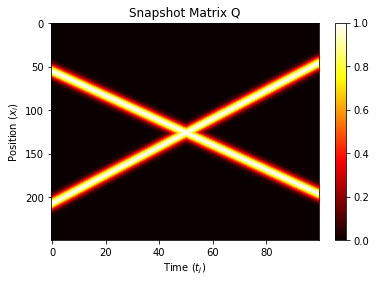

In [22]:
plt.imshow(Q, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time ($t_j$)')
plt.ylabel('Position ($x_i$)')
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [23]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = Q.flatten()

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(inputs_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


# Define a model

In [25]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [26]:
class ShapeShiftNet(nn.Module):
    def __init__(self, p_init_coeffs1, p_init_coeffs2):
        super(ShapeShiftNet, self).__init__()
        
        self.alphas1 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs1[::-1]]
        )
        self.alphas2 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs2[::-1]]
        )
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 64)
        self.f1_fc2 = nn.Linear(64, 64)
        self.f1_fc3 = nn.Linear(64, 64)
        self.f1_fc4 = nn.Linear(64, 1)
        
        self.shift1_fc1 = nn.Linear(1, 32)
        self.shift1_fc2 = nn.Linear(32, 32)
        self.shift1_fc3 = nn.Linear(32, 1)

        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 64)
        self.f2_fc2 = nn.Linear(64, 64)
        self.f2_fc3 = nn.Linear(64, 64)
        self.f2_fc4 = nn.Linear(64, 1)
        
        self.shift2_fc1 = nn.Linear(1, 32)
        self.shift2_fc2 = nn.Linear(32, 32)
        self.shift2_fc3 = nn.Linear(32, 1)
        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = sum([coeff * t**i for i, coeff in enumerate(self.alphas1)])
        #shift1 = self.elu(self.shift1_fc1(t))
        #shift1 = self.elu(self.shift1_fc2(shift1))
        #shift1 = self.shift1_fc3(shift1)
        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.alphas2)])
        #shift2 = self.elu(self.shift2_fc1(t))
        #shift2 = self.elu(self.shift2_fc2(shift2))
        #shift2 = self.shift2_fc3(shift2)
        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift


In [27]:
init_coefficients1 = [-1,1]
init_coefficients2 = [1,1]

In [28]:
model = ShapeShiftNet(init_coefficients1,init_coefficients2)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
num_epochs = 1000

for epoch in range(num_epochs+1):
    for batch_inputs, batch_targets in data_loader:
        x, t = batch_inputs[:, 0:1], batch_inputs[:, 1:2]
        optimizer.zero_grad()
        f1_pred, f2_pred, shift1_pred, shift2_pred, f1_pred_nos, f2_pred_nos = model(x, t)
        loss = torch.norm(batch_targets - f1_pred - f2_pred, 'fro')**2 #+ NuclearNormAutograd.apply(f1_pred_nos) + NuclearNormAutograd.apply(f2_pred_nos)
        loss.backward()
        optimizer.step()
                
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Epoch 0/1000, Loss: 3.403212785720825
Epoch 100/1000, Loss: 0.012834841385483742
Epoch 200/1000, Loss: 0.03698922321200371
Epoch 300/1000, Loss: 0.02014322765171528
Epoch 400/1000, Loss: 0.02695615217089653



KeyboardInterrupt



In [30]:
with torch.no_grad():
    f1_output, f2_output, shift1_pred, shift2_pred, f1_output_nos, f2_output_nos = model(inputs_tensor[:, 0:1], inputs_tensor[:, 1:2])

combined = f1_output + f2_output
Q_tilde = combined.view(Nx, Nt).numpy()
f1_matrix = f1_output.view(Nx, Nt).numpy()
f2_matrix = f2_output.view(Nx, Nt).numpy()
f1_matrix_nos = f1_output_nos.view(Nx, Nt).numpy()
f2_matrix_nos = f2_output_nos.view(Nx, Nt).numpy()

Text(0, 0.5, 'Position ($x_i$)')

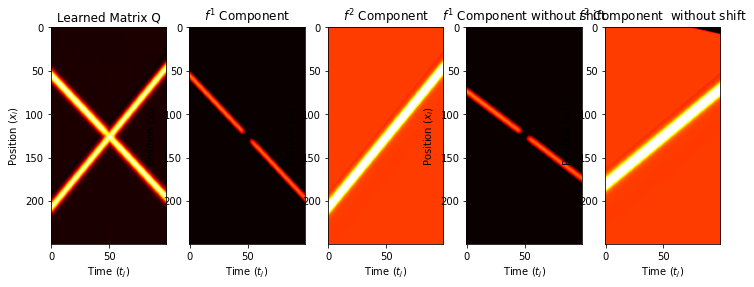

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].imshow(Q_tilde, vmin=vmin, vmax=vmax, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, vmin=vmin, vmax=vmax, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].imshow(f1_matrix_nos, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[3].set_title('$f^1$ Component without shift')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].imshow(f2_matrix_nos, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[4].set_title('$f^2$ Component  without shift')
axs[4].set_xlabel('Time ($t_j$)')
axs[4].set_ylabel('Position ($x_i$)')

Text(0, 0.5, 'Position ($x_i$)')

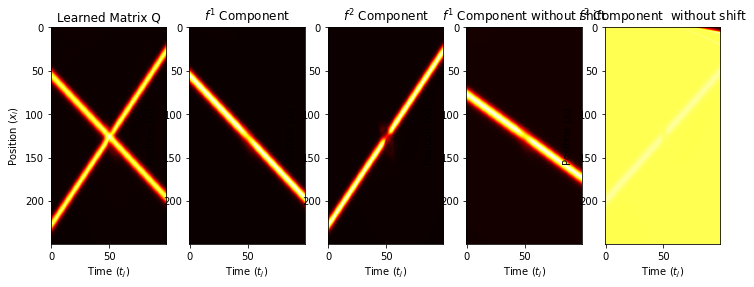

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))

#Qtilde
axs[0].imshow(Q_tilde, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].imshow(f1_matrix_nos, cmap='hot', aspect='auto')
axs[3].set_title('$f^1$ Component without shift')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].imshow(f2_matrix_nos, cmap='hot', aspect='auto')
axs[4].set_title('$f^2$ Component  without shift')
axs[4].set_xlabel('Time ($t_j$)')
axs[4].set_ylabel('Position ($x_i$)')

Text(0, 0.5, 'Position ($x_i$)')

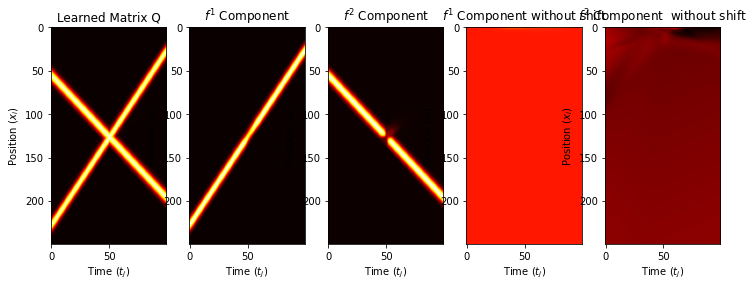

In [57]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))

#Qtilde
axs[0].imshow(Q_tilde, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].imshow(f1_matrix_nos, cmap='hot', aspect='auto')
axs[3].set_title('$f^1$ Component without shift')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].imshow(f2_matrix_nos, cmap='hot', aspect='auto')
axs[4].set_title('$f^2$ Component  without shift')
axs[4].set_xlabel('Time ($t_j$)')
axs[4].set_ylabel('Position ($x_i$)')

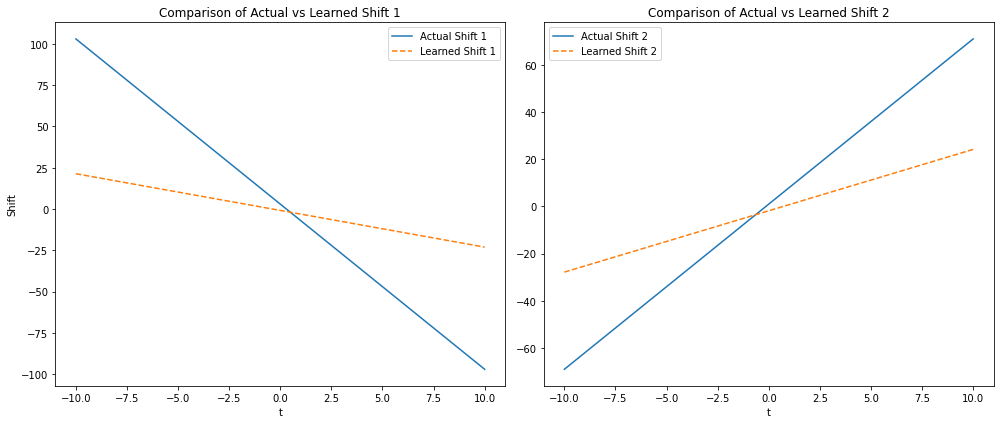

In [16]:
shift_1_pred = shift1_pred.numpy().flatten()
shift_2_pred = shift2_pred.numpy().flatten()

actual_shift1 = np.polyval(coefficients1, inputs_tensor[:, 1:2].flatten())
actual_shift2 = np.polyval(coefficients2, inputs_tensor[:, 1:2].flatten())

plt.figure(figsize=(14, 6))

# Plot for the first shift
plt.subplot(1, 2, 1)
plt.plot(inputs_tensor[:, 1:2].flatten(), actual_shift1, label='Actual Shift 1')
plt.plot(inputs_tensor[:, 1:2].flatten(), shift_1_pred, label='Learned Shift 1', linestyle='--')
plt.title('Comparison of Actual vs Learned Shift 1')
plt.xlabel('t')
plt.ylabel('Shift')
plt.legend()

# Plot for the second shift
plt.subplot(1, 2, 2)
plt.plot(inputs_tensor[:, 1:2].flatten(), actual_shift2, label='Actual Shift 2')
plt.plot(inputs_tensor[:, 1:2].flatten(), shift_2_pred, label='Learned Shift 2', linestyle='--')
plt.title('Comparison of Actual vs Learned Shift 2')
plt.xlabel('t')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
inputs_tensor[:, 1:2]

torch.Size([25000, 1])

## Wildlandfire 2D

In [81]:
def generate_wildlandfire_data(grid, time, snapshot, shifts):
    x = np.load(grid, allow_pickle=True)[0]
    t = np.load(time)
    L = x[-1]
    Nx = len(x)
    Nt = len(t)
    q = np.load(snapshot)
    Q = q[:Nx, :]  # Temperature
    # Q = q[Nx:, :]  # Supply mass
    shift_list = np.load(shifts)
    [X, T] = meshgrid(x, t)
    X = X.T
    T = T.T
    dx = x[1] - x[0]
    nmodes = [2, 2]

    return Q, shift_list, L, dx, Nx, Nt, nmodes, x, t

In [16]:
prefix = "small_wildlandfire"

fields, shift_list, L, dx, Nx, Nt, nmodes, x, t = generate_wildlandfire_data(
    f"../{prefix}/1D_Grid.npy",
    f"../{prefix}/Time.npy",
    f"../{prefix}/SnapShotMatrix558.49.npy",
    f"../{prefix}/Shifts558.49.npy",
)

In [17]:
qmat = np.reshape(fields, [Nx, Nt])

In [18]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = qmat.flatten()

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1)

dataset = TensorDataset(inputs_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [19]:
model = ShapeShiftNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
num_epochs = 100000
for epoch in range(num_epochs+1):
    for batch_inputs, batch_targets in data_loader:
        x, t = batch_inputs[:, 0:1], batch_inputs[:, 1:2]
        
        optimizer.zero_grad()
        
        f1_pred, f2_pred, f3_pred, shift1_pred, shift2_pred, shift3_pred, f1_pred_nos, f2_pred_nos, f3_pred_nos = model(x, t)
        
        TV_f1 = total_variation(x,t,f1_pred, shift1_pred, f1_pred_nos)
        TV_f2 = total_variation(x,t,f2_pred, shift2_pred, f2_pred_nos)
        TV_f3 = total_variation(x,t,f3_pred, shift3_pred, f3_pred_nos)
        #TV_shift1 = total_variation_shift(shift1_pred)
        #TV_shift2 = total_variation_shift(shift2_pred)

        
        loss = torch.norm(batch_targets - f1_pred - f2_pred - f3_pred, 'fro')**2 
        loss += (NuclearNormAutograd.apply(f1_pred_nos) + NuclearNormAutograd.apply(f2_pred_nos) + NuclearNormAutograd.apply(f3_pred_nos))
        #loss += TV_shift1 + TV_shift2
        loss += TV_f1 + TV_f2 + TV_f3
        
        loss.backward()
        
        optimizer.step()
                
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

Epoch 0/100000, Loss: 2238838.75
Epoch 100/100000, Loss: 4556.48974609375
Epoch 200/100000, Loss: 1592.0
Epoch 300/100000, Loss: 4728.95166015625
Epoch 400/100000, Loss: 1748.0474853515625
Epoch 500/100000, Loss: 2454.112060546875
Epoch 600/100000, Loss: 2514.857421875
Epoch 700/100000, Loss: 2789.449462890625
Epoch 800/100000, Loss: 1409.626708984375


KeyboardInterrupt: 

In [29]:
with torch.no_grad():
    f1_output, f2_output, f3_output, _, _,_,f1_output_nos,f2_output_nos, _ = model(inputs_tensor[:, 0:1], inputs_tensor[:, 1:2])

combined = f1_output + f2_output +f3_output
Q_tilde = combined.view(Nx, Nt).numpy()
f1_matrix = f1_output.view(Nx, Nt).numpy()
f2_matrix = f2_output.view(Nx, Nt).numpy()
f3_matrix = f3_output.view(Nx, Nt).numpy()
f1_matrix_nos = f1_output_nos.view(Nx, Nt).numpy()
f2_matrix_nos = f2_output_nos.view(Nx, Nt).numpy()

Text(0, 0.5, 'Position ($x_i$)')

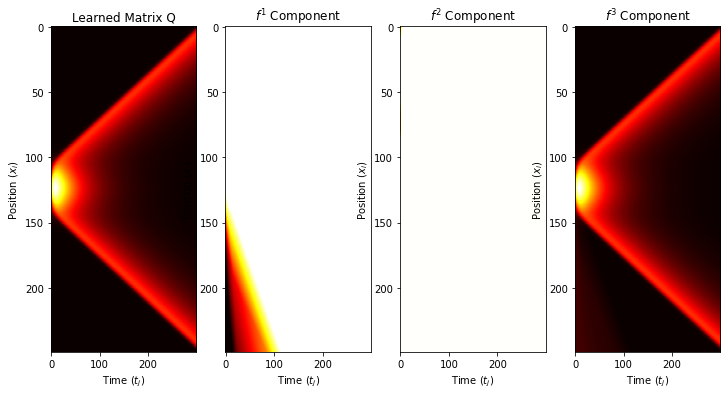

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

#Qtilde
axs[0].imshow(Q_tilde, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

axs[3].imshow(f3_matrix, cmap='hot', aspect='auto')
axs[3].set_title('$f^3$ Component')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')